In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from helpers import parse_variables, get_risk_level
import subprocess
from scipy import stats

In [2]:
naming_dict = {
    "no_risk": "no environmental risk",
    "NW_risk": "Smooth linear North-West environmental risk",
    "N_risk" : "Smooth linear North environmental risk",
    "blob_risk": "Localised big blob risk",
    "center_risk": "Localised big central risk",
    "big_square_risk": "big square risk",
    "square_risk" : "Tiny square risk",
    'hi_square_risk' : "Tiny square risk",
    "hi_gauss_blob_risk": "Global Gaussian Risk",
    "two_square_risk": "Two tiny risks"
}

In [3]:
dict = parse_variables('geno_simulation.txt')
G = int(dict['G'])
L = int(dict['L'])
c = int(dict['c'])
k = int(dict['k'])
M = float(dict['M'])

# Thresholds
very_rare_threshold_L = float(dict['very_rare_threshold_L'])
very_rare_threshold_H = float(dict['very_rare_threshold_H'])

rare_threshold_L = float(dict['rare_threshold_L'])
rare_threshold_H = float(dict['rare_threshold_H'])

common_threshold_L = float(dict['common_threshold_L'])
common_threshold_H = float(dict['common_threshold_H'])

In [4]:
risk_level = get_risk_level()
risk_level = risk_level.split("\n")[-1]
name_risk = risk_level.split('_fun')[0]
name_risk

'two_square_risk'

In [5]:
end_name_file = f"_pvals_nocorr_PC_rarePC_pheno_{name_risk}_G{G}_L{L}_c{c}_k{k}_M{M}.pkl"

In [6]:
iterations = 10

In [7]:
nr_common_PCs = 2
nr_rare_PCs = 5

# Expected P_values

In [8]:
# Define the command to execute
#command = f"cd scripts && python '01_iterate_no_covs_no_risk.py' {iterations}"

In [9]:
# Execute the command
#process = subprocess.Popen(command, shell=True)

# Wait for the process to finish
#process.wait()

# Once the process is finished, you can continue with the rest of your code
#print("The Python script has finished executing.")

In [10]:
#expected_p_values = pd.read_pickle(f"data/iterative_pvalues/pvals_expected_pheno_no_risk_G{G}_L{L}_c{c}_k{k}_M{M}.pkl")
#expected_p_values

# No correction

In [11]:
# Define the command to execute
command = f"cd scripts && python '02_iterate_no_correction.py' {iterations}"

In [12]:
# Execute the command
process = subprocess.Popen(command, shell=True)

# Wait for the process to finish
process.wait()

# Once the process is finished, you can continue with the rest of your code
print("The Python script has finished executing.")

The Python script has finished executing.


In [13]:
nocorr_p_values = pd.read_pickle(f"data/iterative_pvalues/pvals_nocorr_pheno_{name_risk}_G{G}_L{L}_c{c}_k{k}_M{M}.pkl")
nocorr_p_values

,snps,-logP_no_corr,P_val
0,G1,0.002398,0.445874
1,G2,0.003348,0.210542
2,G3,0.004412,0.285537
3,G4,0.006780,0.260660
4,G5,0.008351,0.574502
...,...,...,...
489,G496,4.867784,0.015489
490,G497,5.349749,0.559996
491,G498,5.667209,0.295669
492,G499,5.901243,0.106759


# Genomic control

In [62]:
median_chi2 = np.median(stats.chi2.ppf(1 - nocorr_p_values["P_val"], 1))
expected_median = stats.chi2.ppf(0.5, 1)
lambda_gc = median_chi2 / expected_median
#percent = 5
#lambda_gc = lambda_gc/100 * percent
corrected_p_values = stats.chi2.sf((stats.chi2.ppf(1 - nocorr_p_values["P_val"], 1)) / np.sqrt(lambda_gc), 1)
genomic_control_p_values = nocorr_p_values[['snps']]
genomic_control_p_values['P_val_GC'] = list(corrected_p_values)
genomic_control_p_values['-logP_GC'] = np.sort(-np.log10(genomic_control_p_values['P_val_GC']))
genomic_control_p_values

/tmp/ipykernel_23500/3150923309.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genomic_control_p_values['P_val_GC'] = list(corrected_p_values)


,snps,P_val_GC,-logP_GC
0,G1,0.431898,0.096061
1,G2,0.339820,0.111983
2,G3,0.477340,0.122515
3,G4,0.299511,0.130225
4,G5,0.461955,0.132447
...,...,...,...
489,G496,0.022774,2.030059
490,G497,0.374531,2.309099
491,G498,0.552415,2.474036
492,G499,0.126668,2.651224


In [63]:
epsilon = 1e-100  # Small constant to prevent division by zero

# Add a small constant to p-values to avoid division by zero or extremely small values
p_values_with_epsilon = nocorr_p_values["P_val"] + epsilon

# Calculate the median chi-squared value
median_chi2 = np.median(stats.chi2.ppf(1 - p_values_with_epsilon, 1))
expected_median = stats.chi2.ppf(0.5, 1)
lambda_gc = median_chi2 / expected_median
percent = 20
lambda_gc = (lambda_gc / 100)*percent
# Correct test statistics
corrected_p_values = stats.chi2.sf((stats.chi2.ppf(1 - p_values_with_epsilon, 1)) / np.sqrt(lambda_gc), 1)

# Create DataFrame for genomic control corrected p-values
genomic_control_p_values = pd.DataFrame({
    'snps': nocorr_p_values['snps'],
    'P_val_GC': corrected_p_values+ epsilon,
    '-logP_GC': np.sort(-np.log10(corrected_p_values+ epsilon))
})

# Classical PCA

In [64]:
# Define the command to execute
command = f"cd scripts && python '03_iterate_commonPCs.py' {iterations} {nr_common_PCs}"

In [65]:
# Execute the command
process = subprocess.Popen(command, shell=True)

# Wait for the process to finish
process.wait()

# Once the process is finished, you can continue with the rest of your code
print("The Python script has finished executing.")

The Python script has finished executing.


In [66]:
commonPC_p_values = pd.read_pickle(f"data/iterative_pvalues/pvals_PCcommon_pheno_{name_risk}_G{G}_L{L}_c{c}_k{k}_M{M}.pkl")
commonPC_p_values

,snps,-logP_common_PC
0,G1,0.002130
1,G2,0.003743
2,G3,0.005672
3,G4,0.006807
4,G5,0.008331
...,...,...
489,G496,4.275623
490,G497,4.664908
491,G498,5.040588
492,G499,5.556555


# Rare PCA

In [67]:
# Define the command to execute
command = f"cd scripts && python '04_iterate_rarePCs.py' {iterations} {nr_rare_PCs}"

In [68]:
# Execute the command
process = subprocess.Popen(command, shell=True)

# Wait for the process to finish
process.wait()

# Once the process is finished, you can continue with the rest of your code
print("The Python script has finished executing.")

The Python script has finished executing.


In [69]:
rarePC_p_values = pd.read_pickle(f"data/iterative_pvalues/pvals_PCrare_pheno_{name_risk}_G{G}_L{L}_c{c}_k{k}_M{M}.pkl")
rarePC_p_values

,snps,-logP_rare_PC
0,G1,0.000981
1,G2,0.002241
2,G3,0.004071
3,G4,0.005967
4,G5,0.007719
...,...,...
489,G496,4.225636
490,G497,4.336499
491,G498,4.476168
492,G499,4.716591


# Abyss

In [70]:
command = f"cd scripts && python '05_iterate_abyss.py' {iterations}"
# Execute the command
process = subprocess.Popen(command, shell=True)

# Wait for the process to finish
process.wait()

# Once the process is finished, you can continue with the rest of your code
print("The Python script has finished executing.")

Singular matrix
Singular matrix
The Python script has finished executing.


In [74]:
abyss_p_values = pd.read_pickle(f"data/iterative_pvalues/pvals_abyss_pheno_{name_risk}_G{G}_L{L}_c{c}_k{k}_M{M}.pkl")
abyss_p_values

,snps,-logP_abyss
0,G1,0.001289
1,G2,0.002299
2,G3,0.003791
3,G4,0.005698
4,G5,0.006925
...,...,...
489,G496,4.260830
490,G497,4.697504
491,G498,4.910088
492,G499,5.546865


# Deep Abyss

In [75]:
command = f"cd scripts && python '06_iterate_deep_abyss.py' {iterations}"
# Execute the command
process = subprocess.Popen(command, shell=True)

# Wait for the process to finish
process.wait()

# Once the process is finished, you can continue with the rest of your code
print("The Python script has finished executing.")

The Python script has finished executing.


In [76]:
deep_abyss_p_values = pd.read_pickle(f"data/iterative_pvalues/pvals_abyss_deep_pheno_{name_risk}_G{G}_L{L}_c{c}_k{k}_M{M}.pkl")
deep_abyss_p_values

,snps,-logP_abyss_deep
0,G1,0.001297
1,G2,0.002247
2,G3,0.003052
3,G4,0.004574
4,G5,0.005664
...,...,...
489,G496,4.220358
490,G497,4.449148
491,G498,4.902092
492,G499,5.375597


In [77]:
try:
    # Merge df and df_PC on 'snps'
    temp1 = pd.merge(expected_p_values, nocorr_p_values, on='snps')

    # Merge df_Ps_PCs with the already merged dataframe on 'snps'
    temp2 = pd.merge(temp1, commonPC_p_values, on='snps')
except:
    temp2 = pd.merge(nocorr_p_values, commonPC_p_values, on='snps')
    temp3 = pd.merge(temp2, rarePC_p_values, on='snps')
    temp4 = pd.merge(temp3, genomic_control_p_values[['snps','-logP_GC']], on='snps')
    temp5 = pd.merge(temp4, abyss_p_values[['snps','-logP_abyss']], on='snps')
    final_merged = pd.merge(temp5, deep_abyss_p_values[['snps','-logP_abyss_deep']], on='snps')

In [78]:
n = len(final_merged)
expected_quantiles = np.arange(1, n + 1) / n
expected_quantiles = np.sort(-np.log10(expected_quantiles))
final_merged["expected_log_P"] = expected_quantiles

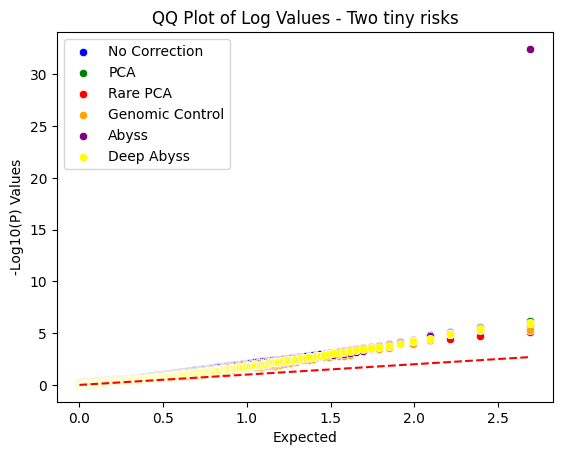

In [80]:
# Plot log10_p_no_corr
sns.scatterplot(x='expected_log_P', y='-logP_no_corr', data=final_merged, color='blue', label='No Correction')

# Plot log10_p_PCs
sns.scatterplot(x='expected_log_P', y='-logP_common_PC', data=final_merged, color='green', label='PCA')

# Plot log10_p_rare_PCs
sns.scatterplot(x='expected_log_P', y='-logP_rare_PC', data=final_merged, color='red', label='Rare PCA')

sns.scatterplot(x='expected_log_P', y='-logP_GC', data=final_merged, color='orange', label='Genomic Control')

sns.scatterplot(x='expected_log_P', y='-logP_abyss', data=final_merged, color='purple', label='Abyss')

sns.scatterplot(x='expected_log_P', y='-logP_abyss_deep', data=final_merged, color='yellow', label='Deep Abyss')


# Plot diagonal reference line
plt.plot([min(final_merged['expected_log_P']), max(final_merged['expected_log_P'])], 
         [min(final_merged['expected_log_P']), max(final_merged['expected_log_P'])], 
         color='red', linestyle='--')

# Set plot labels and title
plt.xlabel('Expected')
plt.ylabel('-Log10(P) Values')
plt.title(f"QQ Plot of Log Values - {naming_dict[name_risk]}")

# Show legend
plt.legend()
plt.savefig(f"data/plots/qq_pheno_{name_risk}_iter_{iterations}_G{G}_L{L}_c{c}_k{k}_M{M}.png", dpi=100)
# Show plot
plt.show()